In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=10ecbc65154be71d369e55fe25876f765b1b01d89bc07e4c26a5dff9a9739d2b
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
import os
import math
import random
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import notebook
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn

from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.lr_scheduler import _LRScheduler
from torchvision import transforms as T

from torch.utils.tensorboard import SummaryWriter
from efficientnet_pytorch import EfficientNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/isl/data.zip', '/content/')

'/content/data.zip'

In [ ]:
!unzip data.zip

In [ ]:
class configs:
    IMAGE_SIZE = 224
    NUM_WORKERS = 2
    BATCH_SIZE = 32
    EPOCHS = 100
    SEED = 69
    CHECKPOINT = "/content/drive/MyDrive/isl/data.zip/cnn_eff0_model.pt"
    MODEL_NAME = 'efficientnet-b0'
    scheduler_params = {
        "lr_start": 3e-5,
        "lr_max": 3e-5 * BATCH_SIZE,
        "lr_min": 1e-6,
        "lr_ramp_ep": 5,
        "lr_sus_ep": 0,
        "lr_decay": 0.8,
    }

    model_params = {
    'model_name':MODEL_NAME,
    'in_channels':3,
    'image_size':IMAGE_SIZE,
    'num_classes':35,
    }

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def seed_torch(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(configs.SEED)

In [ ]:
train_trns = T.Compose([
    T.ToPILImage(),
    T.Resize(size = (configs.IMAGE_SIZE,configs.IMAGE_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=(0.8,1.2)),
    T.RandomAffine(degrees=(-10,10),translate =(0.1,0.1),shear =(-5,5,-5,5),interpolation = T.InterpolationMode.BILINEAR),
    T.RandomPerspective(distortion_scale=0.3),
    T.ToTensor(),
    T.RandomApply([T.Lambda(lambda x : x + (0.1**0.7)*torch.randn(3,configs.IMAGE_SIZE,configs.IMAGE_SIZE))],p=0.08),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_trns = T.Compose([
    T.ToPILImage(),
    T.Resize(size = (configs.IMAGE_SIZE,configs.IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize((0.445), (0.269))
])

In [ ]:
import pathlib,glob,os
data_loc = r"./data"
data_loc = pathlib.Path(data_loc)
all_data = list(data_loc.glob('*/*.jpg'))

In [ ]:
all_data[0]

PosixPath('data/9/703.jpg')

In [ ]:
from tqdm import tqdm
file = open('cnn_data.txt',"w+")
file.write('img_loc'+','+'label' + "\n")
for i,x in enumerate(tqdm(all_data)):
    w = str(x) + "," + str(x).split('/')[-2] + "\n"
    file.write(w)
file.close()

100%|██████████| 42000/42000 [00:00<00:00, 228423.64it/s]


In [ ]:
df = pd.read_csv('cnn_data.txt')

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encode = LabelEncoder()
label_encoded = label_encode.fit_transform(df['label'])
df['target'] = label_encoded

In [ ]:
df_train,df_val = train_test_split(df,test_size = 0.1,stratify=df['target'],random_state = configs.SEED)
df_train.reset_index(drop=True,inplace=True)
df_val.reset_index(drop=True,inplace=True)

In [ ]:
df_train.shape,df_val.shape

((37800, 3), (4200, 3))

In [ ]:
class ASLdata(Dataset):
    def __init__(self,df,transform):
        self.img_locs = list(df.img_loc)
        self.targets = list(df.target)
        self.transform = transform
    def  __len__(self):
        return len(self.targets)
    def __getitem__(self,idx):
        img_loc = str(self.img_locs[idx])
        img = cv2.imread(img_loc)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        target = self.targets[idx]
        return img,target
    def collate_fn(self,batch):
        imgs,targets = list(zip(*batch))
        imgs = [self.transform(img)[None] for img in imgs]
        targets = [torch.tensor(x) for x in targets]
        imgs = torch.cat(imgs).to(device)
        targets = torch.Tensor(targets).long().to(device)
        return imgs,targets

In [ ]:
img = cv2.imread(df_train['img_loc'][0])

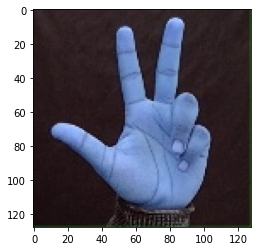

In [ ]:
plt.imshow(img)

In [ ]:
train_ds = ASLdata(df_train,train_trns)
train_loader = DataLoader(train_ds, batch_size=configs.BATCH_SIZE, shuffle=True, drop_last=True,collate_fn = train_ds.collate_fn)
val_ds = ASLdata(df_val,val_trns)
val_loader = DataLoader(val_ds, batch_size=configs.BATCH_SIZE, shuffle=False, drop_last=True,collate_fn = val_ds.collate_fn)


In [ ]:
class CNNModel(nn.Module):
    def __init__(self,model_name='efficientnet-b0',in_channels=3,image_size=224,num_classes=35):
        super(CNNModel,self).__init__()
        self.model = EfficientNet.from_pretrained(model_name=model_name,in_channels=in_channels,image_size=image_size,num_classes=num_classes)

    def forward(self, images):
        return self.model(images)

    def get_loss_acc(self, preds, targets):
        loss = nn.CrossEntropyLoss()(preds,targets)
        preds = torch.argmax(preds,dim=1).cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        acc = metrics.accuracy_score(targets,preds)
        return loss,acc



In [ ]:
class lr_scheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(lr_scheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]

        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1

        return [lr for _ in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return self.base_lrs

    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) /
                  self.lr_ramp_ep * self.last_epoch +
                  self.lr_start)

        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max

        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) +
                  self.lr_min)
        return lr

In [ ]:
class trainer:
    def __init__(self,train_dataloader,val_dataloader,load_checkpoint = False):
        if(load_checkpoint):
            print("Loading pretrained model...")
            self.model = torch.load(configs.CHECKPOINT)
        else:
            self.model  = CNNModel(**configs.model_params)
        no_decay = ['bias','LayerNorm.bias','LayerNorm.weight']
        para_optimizer = list(self.model.named_parameters())
        self.optimizer_parameters = [
        {'params':[p for n,p in para_optimizer if not any(nd in n for nd in no_decay)],'weight_decay':1e-5},
        {'params':[p for n,p in para_optimizer if  any(nd in n for nd in no_decay)],'weight_decay':0.0}
        ]

        self.optimizer = AdamW(amsgrad = True,params = self.optimizer_parameters,lr = 3e-5)
        self.lr_scheduler = lr_scheduler(self.optimizer,**configs.scheduler_params)
        self.criterion = self.model.get_loss_acc
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = self.model.to(device)
        self.writer = SummaryWriter("tboard")
        self.step_train = 0
        self.step_val = 0



    def train_fn(self,epoch):
        self.model.train()
        count,total_loss,total_acc = 0,0,0
        loop = notebook.tqdm(enumerate(self.train_dataloader),total = len(self.train_dataloader))
        for bi,data in loop:
            images = data[0].to(device)
            targets = data[1].to(device)
            preds =  self.model(images)
            self.optimizer.zero_grad()
            loss,acc =self.criterion(preds, targets)
            total_loss += loss.item()
            total_acc += acc
            self.writer.add_scalar("Training Loss",loss.item(),global_step=self.step_train)
            self.writer.add_scalar("Training Accuracy",acc,global_step=self.step_train)
            count +=1
            self.step_train +=1
            loss.backward()
            self.optimizer.step()
            loop.set_postfix(Epoch=epoch,Avg_Train_Loss=total_loss/count,Avg_Train_Acc=total_acc/count,Current_Train_Loss=loss.item(),Current_Train_Acc=acc,LR=self.optimizer.param_groups[0]['lr'])
        self.lr_scheduler.step()

    def eval_fn(self,epoch):
        self.model.eval()
        count,total_loss,total_acc = 0,0,0
        with torch.no_grad():
            loop = notebook.tqdm(enumerate(self.val_dataloader),total = len(self.val_dataloader))
            for bi,data in loop:
                images = data[0].to(device)
                targets = data[1].to(device)
                preds =  self.model(images)
                loss,acc =self.criterion(preds, targets)
                total_loss += loss.item()
                total_acc += acc
                self.writer.add_scalar("Validation Loss",loss.item(),global_step=self.step_val)
                self.writer.add_scalar("Validation Accuracy",acc,global_step=self.step_val)
                count +=1
                self.step_val +=1
                loop.set_postfix(Epoch=epoch,Avg_Val_Loss=total_loss/count,Avg_Val_Acc=total_acc/count,Current_Val_Loss=loss.item(),Current_Val_Acc=acc)

        return total_acc / count

    def run(self,epochs = 5):
        best_acc = 0
        for epoch in range (epochs):
            self.train_fn(epoch)
            val_acc = self.eval_fn(epoch)
            print("Epoch {} complete! Validation Acc : {}".format(epoch, val_acc))
            if val_acc > best_acc:
                print("Best validation Acc improved from {} to {}, saving model...".format(best_acc, val_acc))
                best_acc = val_acc
                torch.save(self.model, configs.CHECKPOINT)


In [ ]:
train = trainer(train_loader,val_loader)

Loaded pretrained weights for efficientnet-b0


In [ ]:
#train.model

In [ ]:
train.run(configs.EPOCHS)


Epoch 0 complete! Validation Acc : 1.0
Best validation Acc improved from 0 to 1.0, saving model...


NotADirectoryError: ignored